In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from batcar.core import Core
from batcar.model_updater.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import RecentSelector
from batcar.model_updater.wrappers import FrameIO
from batcar.update_trigger.periodic_trigger import PeriodicTrigger

In [3]:
plt.style.use('makina-notebook')

# 데이터 생성

## 시간대

In [4]:
data_timestamps = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

## `x`

In [5]:
x = pd.DataFrame(np.arange(len(data_timestamps) * 3).reshape(-1, 3))

x.index = data_timestamps
x.columns = ['a', 'b', 'c']

## 첫 번째 구간: 완만히 증가하는 `y`

In [6]:
n_samples_1 = int(len(x) / 2)

x1 = x.iloc[:n_samples_1]

y1_clean = x1.sum(axis=1)
y1 = (y1_clean + np.random.randn(n_samples_1) * x1.mean(axis=1) * 0.1).to_frame()

## 두 번째 구간: 가파르게 증가하는 `y`

In [7]:
n_samples_2 = len(x) - n_samples_1

x2 = x.iloc[n_samples_1:]

ori = x2.sum(axis=1)
base = ori - ori.iloc[0]
base2 = base * 3

y2_clean = base2 + ori.iloc[0]
y2 = (y2_clean + np.random.randn(n_samples_2) * x2.mean(axis=1) * 0.1).to_frame()

## 전체 y

In [8]:
y = pd.concat([y1, y2])

## 데이터 시각화

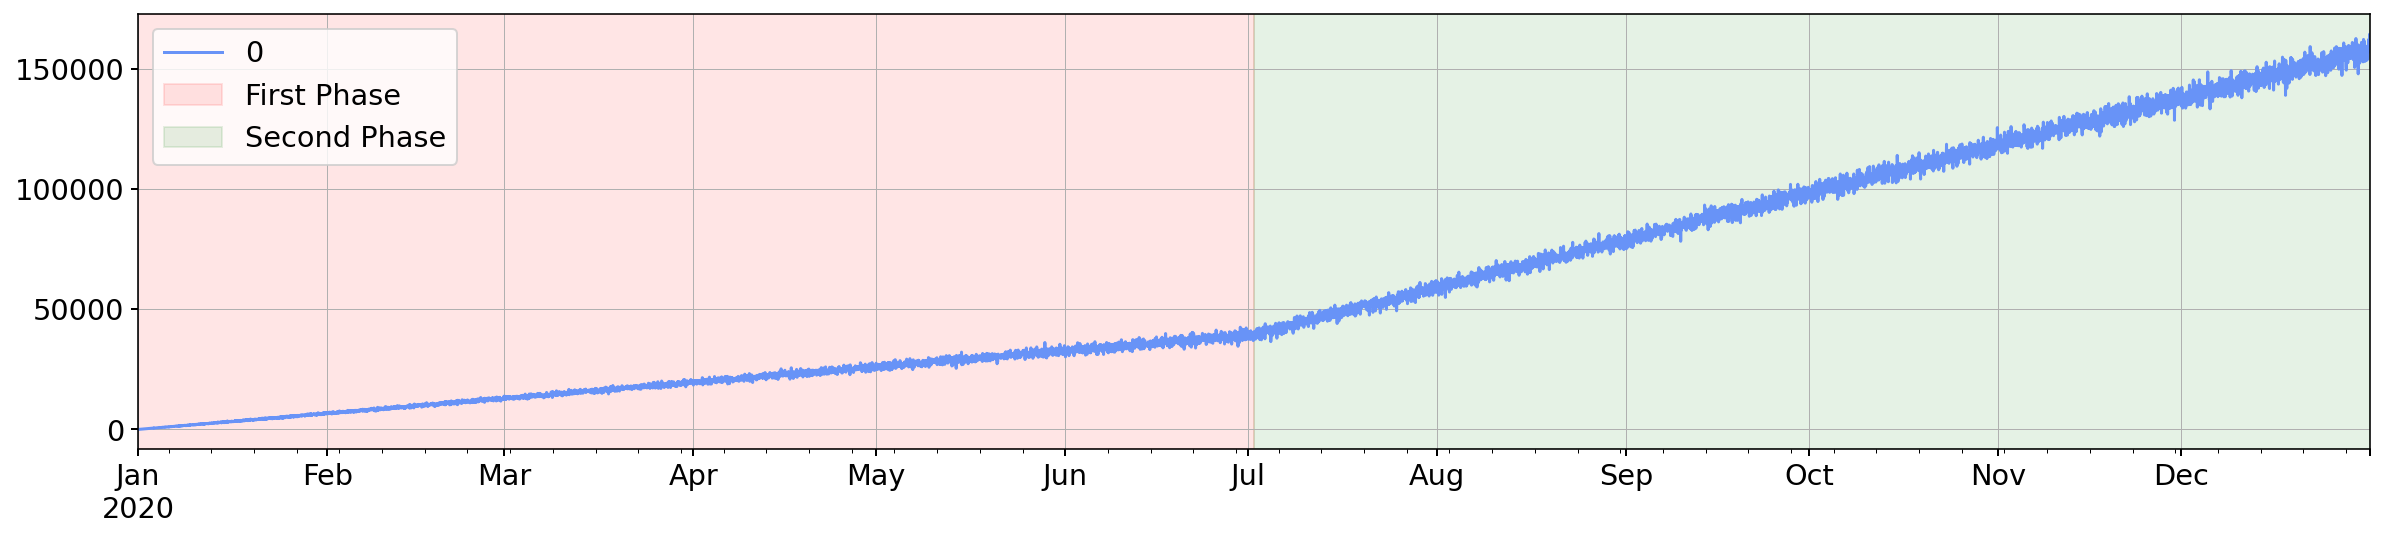

In [9]:
ax = y.plot(figsize=(20, 4))

ax.axvspan(*y1.index[[0, -1]], color='red', alpha=0.1, label='First Phase')
ax.axvspan(*y2.index[[0, -1]], color='green', alpha=0.1, label='Second Phase')
ax.legend()

# 업데이트 방식에 따른 예측 성능 비교

In [10]:
model = FrameIO(Ridge())  # Wrapper to accept DataFrame
update_interval = pd.Timedelta('31 days')

In [11]:
def viz_pred(true, pred):    
    ax = true.iloc[:,0].plot(figsize=(20, 4), lw=3, label='True')
    ax = pred.iloc[:,0].plot(ax=ax, lw=3, label='Pred')

    ax.axvspan(*y1.index[[0, -1]], color='purple', alpha=0.1, label='First Phase')
    ax.axvspan(*y2.index[[0, -1]], color='green', alpha=0.1, label='Second Phase')
    ax.legend()
    
    mse = ((true - pred) ** 2).pow(0.5).mean().mean()
    ax.set_title(f'MSE: {mse:.2}')
    
    return ax

## 업데이트 하지 않음

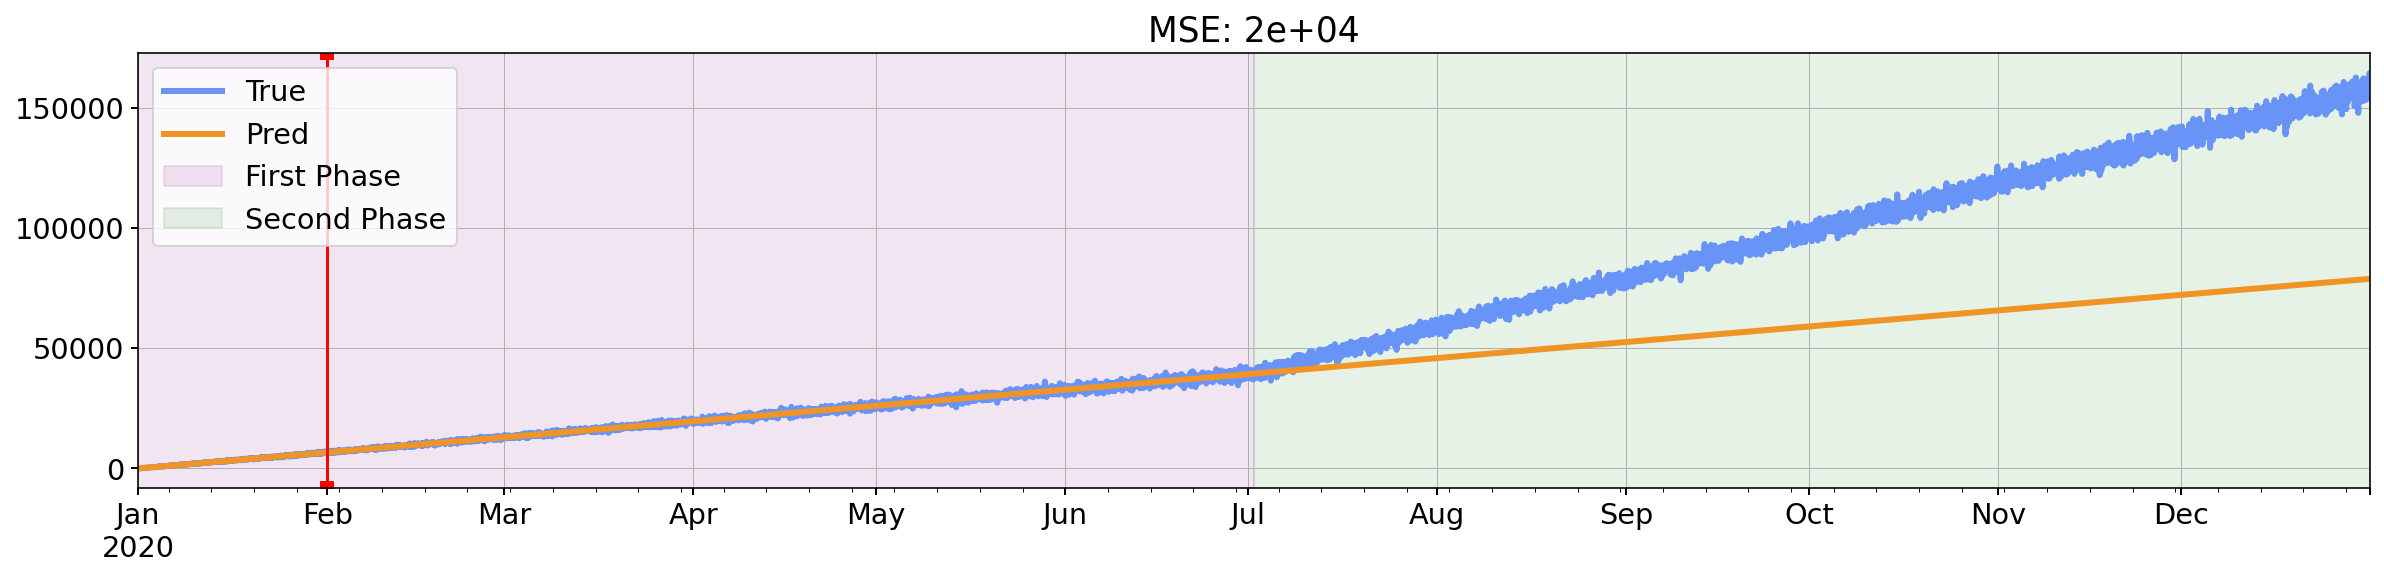

In [12]:
x_train = x.first(pd.Timedelta('31 days'))
y_train = y.loc[x_train.index]

model1 = copy.deepcopy(model)
model1.fit(x_train, y_train)

y_pred = model1.predict(x)

ax = viz_pred(y, y_pred)
ax.axvline(x_train.index[0] + pd.Timedelta('31 days'), lw=1.5, color='red', marker='s')

# Batch 단위로 업데이트 여부 확인 (with BatCar)

Batch 0.0 is Done
Model is updated at 2020-03-24 08:00:00
Batch 1.0 is Done
Model is updated at 2020-06-15 16:00:00
Batch 2.0 is Done
Model is updated at 2020-09-07 00:00:00
Batch 3.0 is Done
Model is updated at 2020-11-29 08:00:00
Batch 4.0 is Done
CPU times: user 256 ms, sys: 9.74 ms, total: 266 ms
Wall time: 242 ms


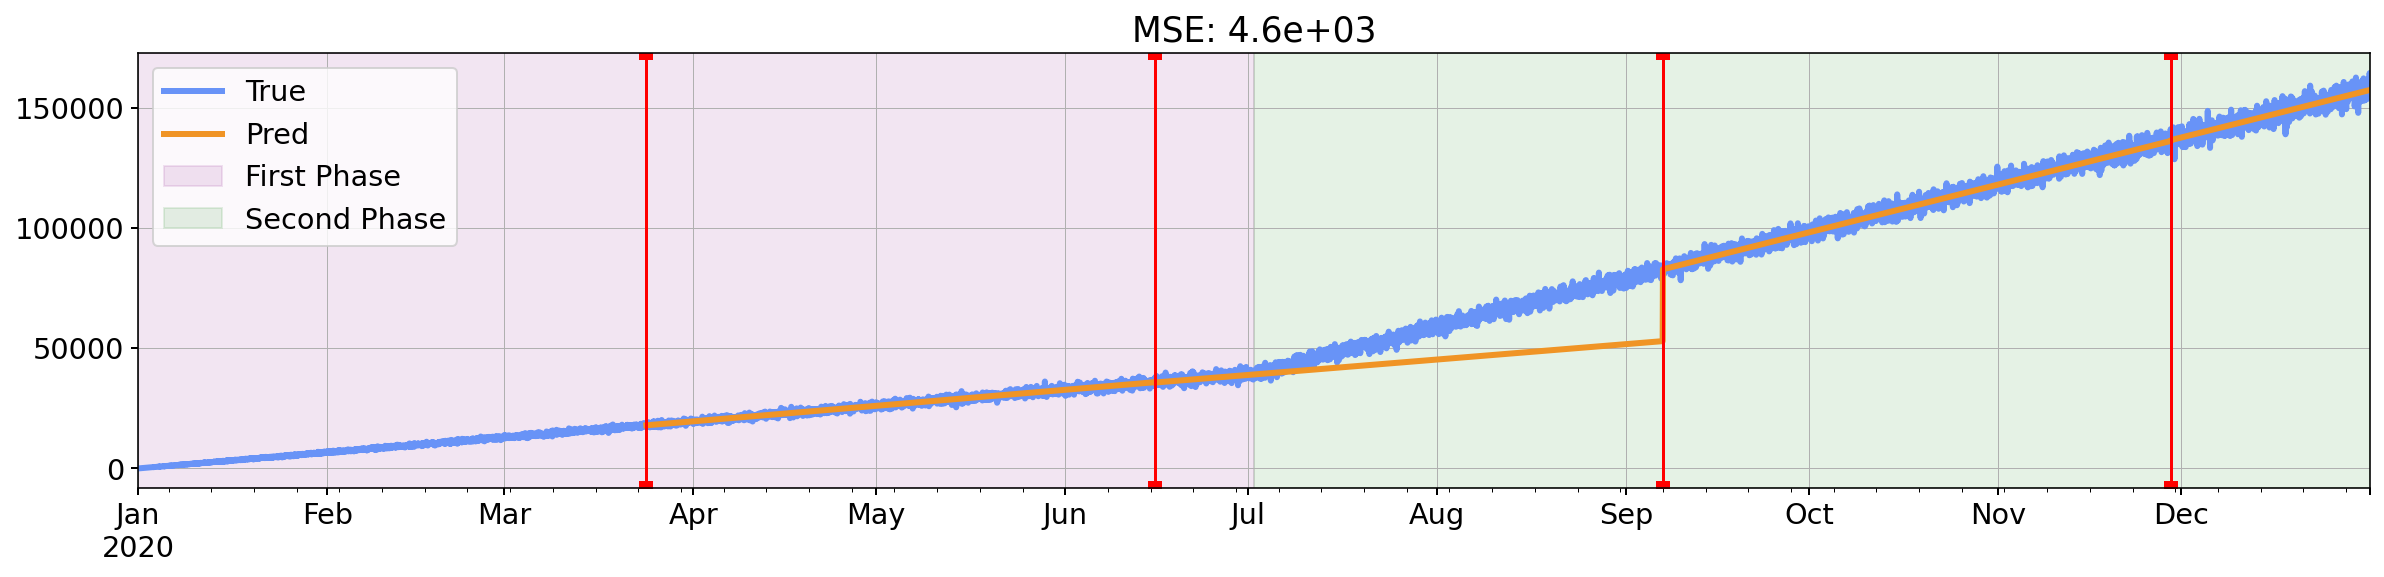

In [13]:
%%time

#
# define UpdateTrigger
#
update_interval = pd.Timedelta('31 days')
update_trigger = PeriodicTrigger(update_interval)

#
# define DataSelector
#
data_selector = RecentSelector(744)  # equal to 31 days

#
# define ModelUpdater
#
model = FrameIO(Ridge())
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

#
# define BatCar
#
batcar = Core(update_trigger, model_updater)
batcar.drive(x, y, batch_size=2000, batch_update=True)

y_pred = batcar.result_table[[0]]

ax = viz_pred(y, y_pred)

for index, row in batcar.model_table.iterrows():
    ax.axvline(row['build_time'], color='red', lw=1.5, marker='s')

# Sample 단위로 업데이트 여부 확인 (with BatCar)

Model is updated at 2020-02-01 00:00:00
Model is updated at 2020-03-03 00:00:00
Batch 0.0 is Done
Model is updated at 2020-04-03 00:00:00
Model is updated at 2020-05-04 00:00:00
Model is updated at 2020-06-04 00:00:00
Batch 1.0 is Done
Model is updated at 2020-07-05 00:00:00
Model is updated at 2020-08-05 00:00:00
Model is updated at 2020-09-05 00:00:00
Batch 2.0 is Done
Model is updated at 2020-10-06 00:00:00
Model is updated at 2020-11-06 00:00:00
Batch 3.0 is Done
Model is updated at 2020-12-07 00:00:00
Batch 4.0 is Done
CPU times: user 6.78 s, sys: 66.9 ms, total: 6.85 s
Wall time: 6.8 s


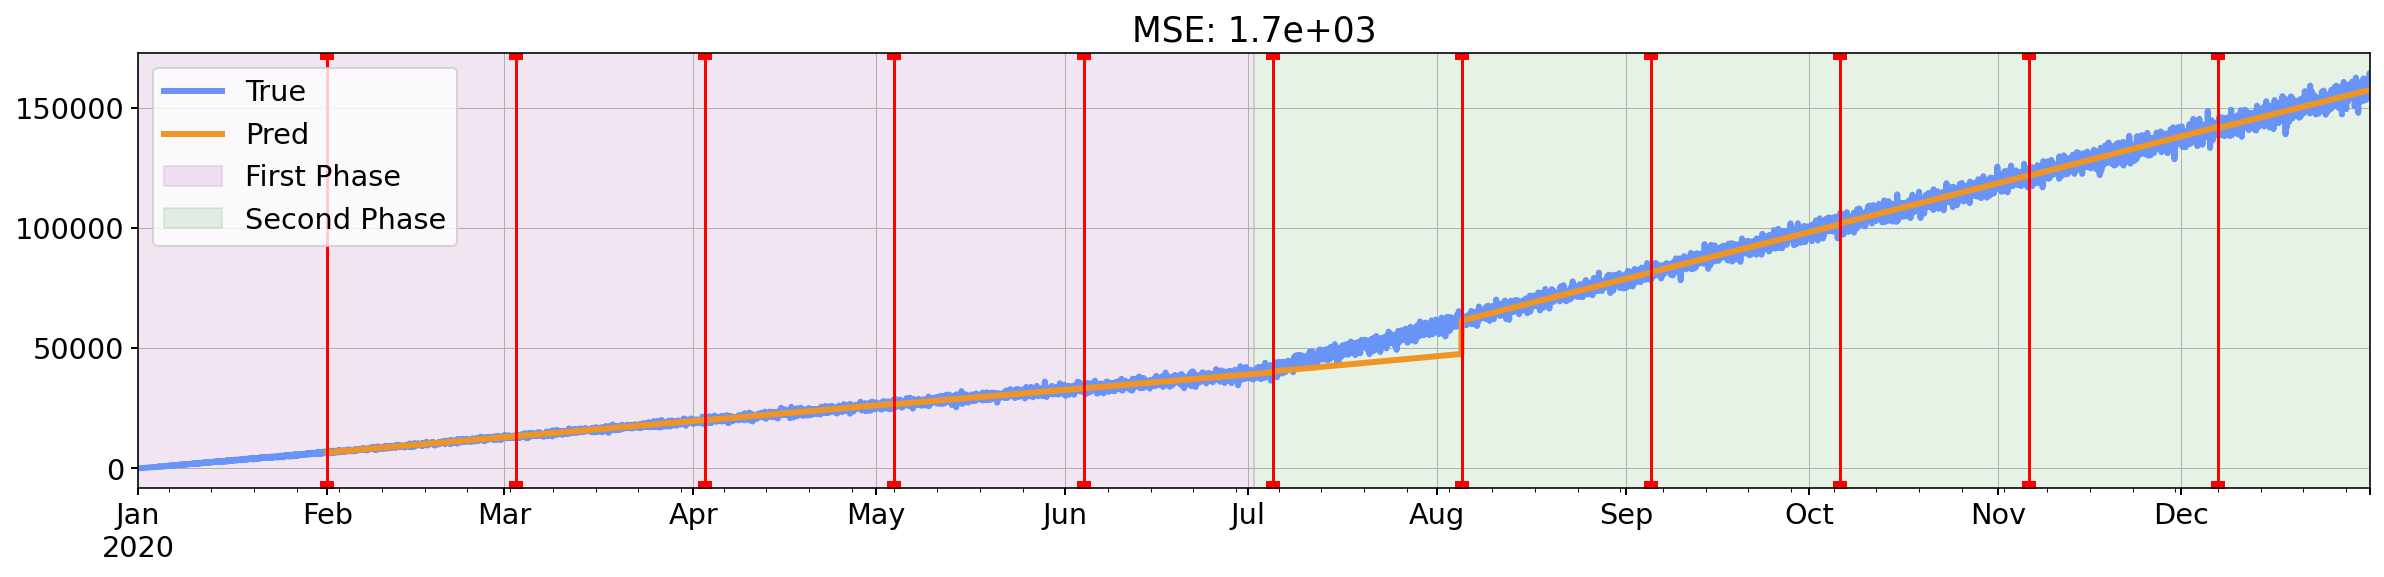

In [14]:
%%time

#
# define UpdateTrigger
#
update_interval = pd.Timedelta('31 days')
update_trigger = PeriodicTrigger(update_interval)

#
# define DataSelector
#
data_selector = RecentSelector(744)  # equal to 31 days

#
# define ModelUpdater
#
model = FrameIO(Ridge())
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

#
# define BatCar
#
batcar = Core(update_trigger, model_updater)
batcar.drive(x, y, batch_size=2000)

y_pred = batcar.result_table[[0]]

ax = viz_pred(y, y_pred)

for index, row in batcar.model_table.iterrows():
    ax.axvline(row['build_time'], color='red', lw=1.5, marker='s')